<a href="https://colab.research.google.com/github/Rishabh9559/Data_science/blob/main/Phase%202%3A%20Machine%20Learning%20for%20Data%20Science/Stacking_AdaBoost_Implement/Stacking_AdaBoost_Implement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stacking Implement

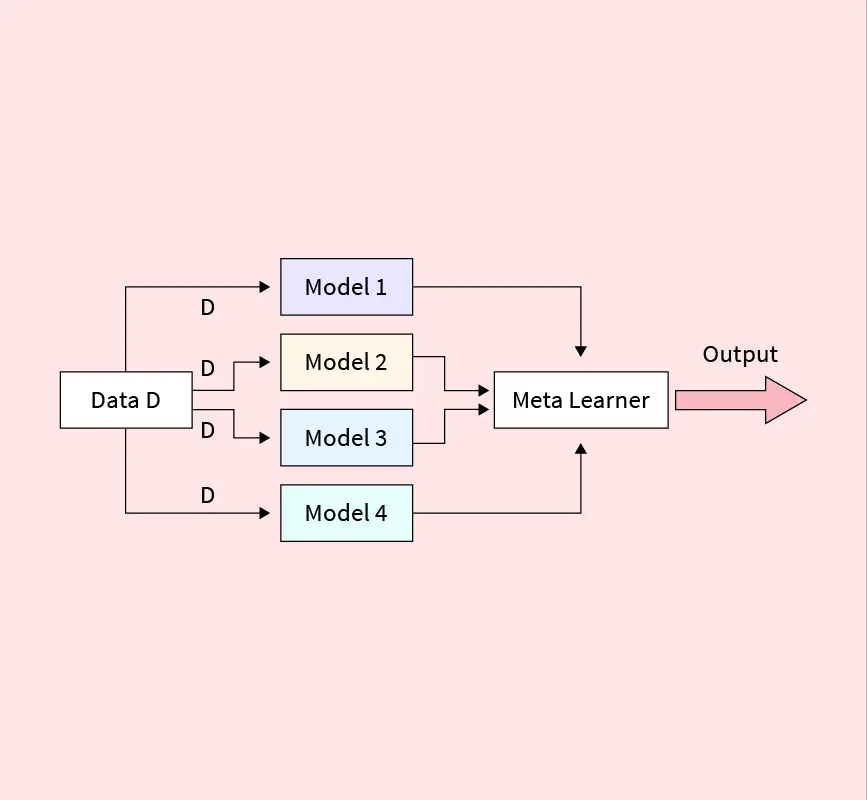

Stacking (or **Stacked Generalization**) is an **ensemble learning technique** where multiple base models are trained and their predictions are combined using a meta-model (or blender) to improve overall performance.




### **Steps to Implement Stacking in Machine Learning**

#### **1. Prepare the Dataset**

* Split the dataset into **training** and **testing** sets.
* Optionally, use **k-fold cross-validation** inside training to generate reliable predictions for the meta-model.



#### **2. Choose Base Models (Level-0 models)**

* Select multiple diverse models (e.g., Decision Tree, Logistic Regression, Random Forest, KNN, SVM, etc.).
* Train them independently on the training set.



#### **3. Generate Base Model Predictions**

* For each base model:

  * Use **k-fold cross-validation** on the training data.
  * Store the **out-of-fold predictions** (predictions on unseen folds).
* These predictions form a **new feature set** (meta-features).


#### **4. Train the Meta-Model (Level-1 model)**

* Use the meta-features (predictions of base models) as input.
* Train a **meta-learner** (often Logistic Regression, XGBoost, or a Neural Network).
* The meta-learner learns **how to combine base model outputs**.



#### **5. Make Final Predictions**

* On the test set:

  * Get predictions from each base model.
  * Feed them into the meta-model.
  * Meta-model gives the final prediction.



### **Advantages of Stacking**

* Combines strengths of different models.
* Usually outperforms individual models or simple ensembles (bagging/boosting).
* Works well with diverse base models.



### **When to Use**

* When base models perform **differently** (not highly correlated).
* When you want to squeeze out extra accuracy in competitions (e.g., Kaggle).




In [1]:
# import package

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split

In [9]:
# load dataset from sklearn
data = load_breast_cancer()
X = data.data
y = data.target


df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

display(df.head())

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


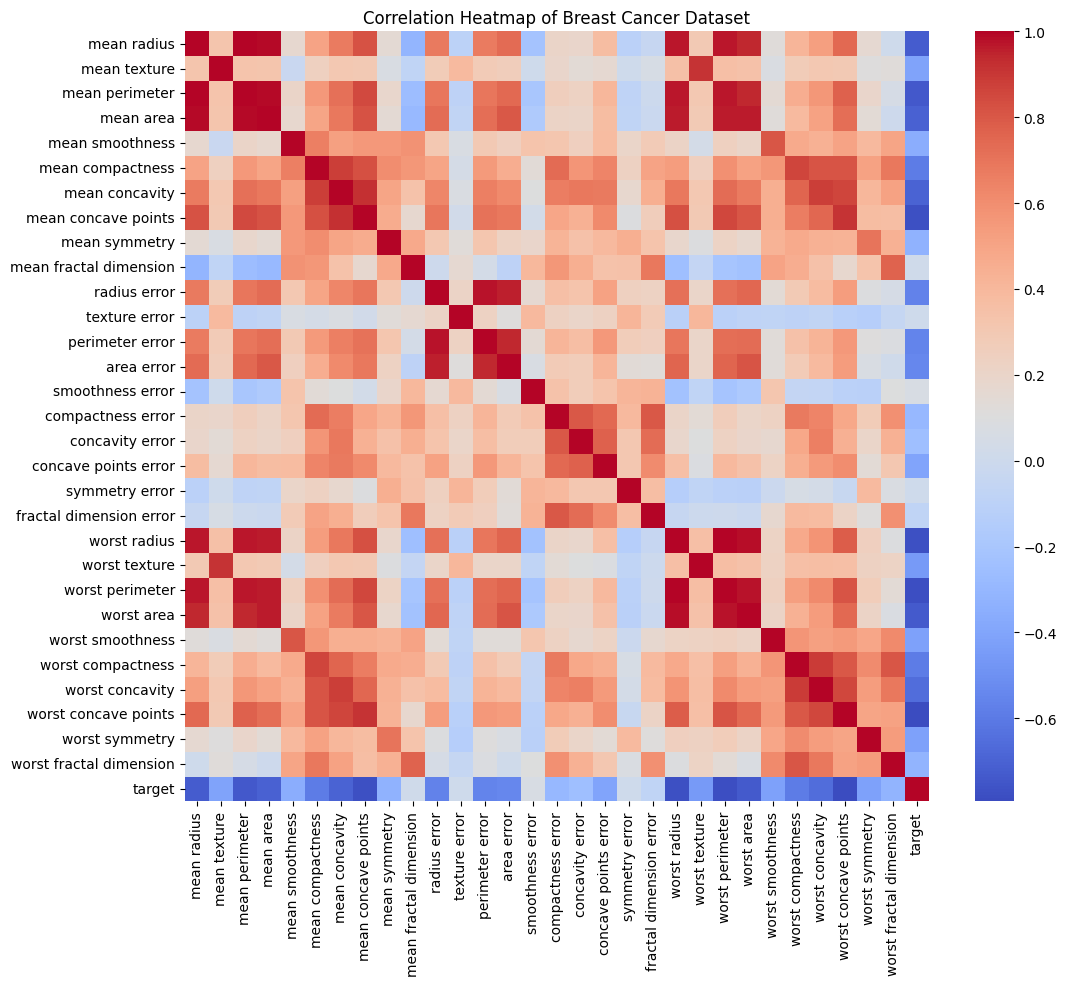

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = df.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Breast Cancer Dataset')
plt.show()

In [10]:
X

array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]])

In [11]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [27]:
# Data split into Train and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=44)

In [28]:
# display the value counts to understand the data balanced or unbalanced
print(pd.Series(y_train).value_counts())

1    282
0    173
Name: count, dtype: int64


In [29]:
# Define the Base learners
base_learners = [
    ('dt', DecisionTreeClassifier(random_state=44)),
    ('lr', LogisticRegression(random_state=44)),
    ('knn', KNeighborsClassifier())
]

In [30]:
# Define the Meta Learner
meta_learner = DecisionTreeClassifier(random_state=44)

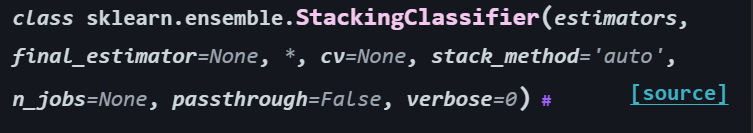


1. **estimators**

   * A list of base models you want to combine.
   * Example: `[('dt', DecisionTreeClassifier()), ('svm', SVC())]`.

2. **final\_estimator**

   * The model that takes the predictions of base models and learns how to combine them.
   * Default = Logistic Regression (if you don’t specify).

3. **cv (cross-validation)**

   * How to split the training data to generate reliable predictions for the meta-model.
   * Example: `cv=5` → **uses 5-fold cross-validation.**

4. **stack\_method**

   * How base models give their output:

     * `"predict_proba"` → probabilities (common for classification).
     * `"decision_function"` → decision scores.
     * `"predict"` → class labels.
     * `"auto"` → scikit-learn chooses automatically.

5. **n\_jobs**

   * Number of CPU cores to use in parallel when training base models.
   * `-1` → use all cores.

6. **passthrough**

   * `False` (default): Meta-model only sees predictions from base models.
   * `True`: Meta-model sees **predictions + original input features**.

7. **verbose**

   * Controls how much information to print while training.
   * `0` = silent, higher numbers = more messages.




### **What is k-Fold Cross Validation?**

It’s a technique to test how well a machine learning model performs, by splitting the dataset into **k equal parts (folds)**.

📌 **Simple example with 10 data points & 5-fold CV:**

* Data: `[1,2,3,4,5,6,7,8,9,10]`
* Split into 5 folds:

  * Fold1: `[1,2]`, Fold2: `[3,4]`, Fold3: `[5,6]`, Fold4: `[7,8]`, Fold5: `[9,10]`.

**Round 1:** Train on `[3–10]`, Test on `[1,2]`
**Round 2:** Train on `[1,2,5–10]`, Test on `[3,4]`
**Round 3:** Train on `[1–4,7–10]`, Test on `[5,6]`
**Round 4:** Train on `[1–6,9,10]`, Test on `[7,8]`
**Round 5:** Train on `[1–8]`, Test on `[9,10]`

Then average the 5 test scores.



In [32]:
# Model Training -> Build and Fit the Stacking Classifer
stack_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner
)

stack_clf.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

StackingClassifier(estimators=[('dt', DecisionTreeClassifier(random_state=44)),
                               ('lr', LogisticRegression(random_state=44)),
                               ('knn', KNeighborsClassifier())],
                   final_estimator=DecisionTreeClassifier(random_state=44))

In [33]:
# Model Prediction
y_pred = stack_clf.predict(X_test)
y_pred

array([0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0])

In [36]:
# model Evaluation
accuracy_score(y_test,y_pred)

0.9385964912280702

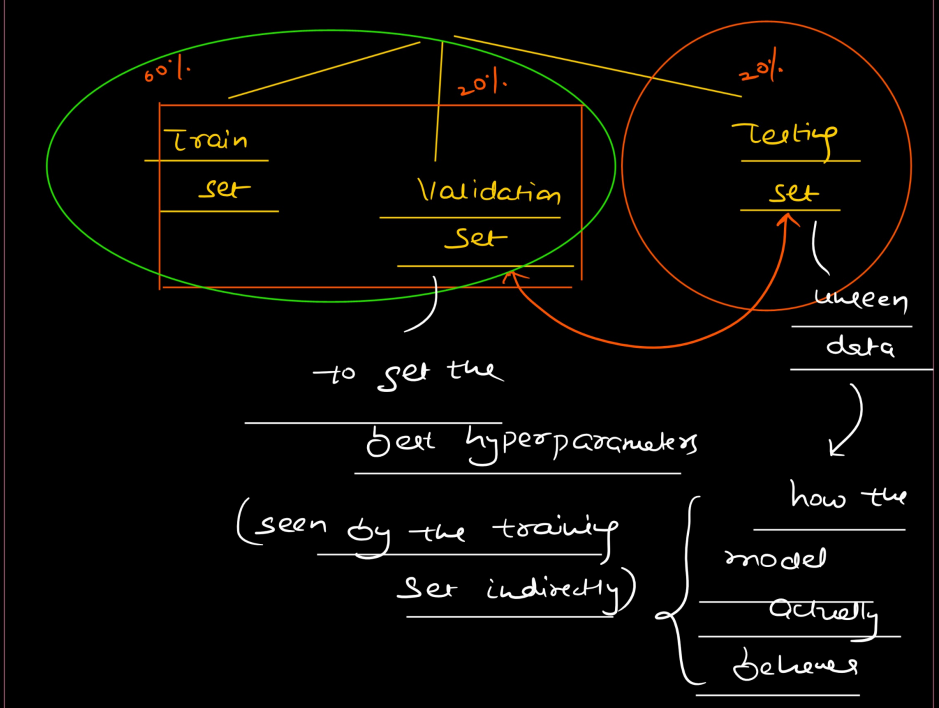

##Boosting in ML
**Boosting itself is NOT a single ML model.**

**It is an ensemble learning technique (a strategy) that builds a strong model by combining many weak models (usually decision trees).**

Boosting is an ensemble technique in machine learning.

* It combines multiple weak learners (models that perform slightly better than random guessing, e.g., small decision trees).

* Learners are trained sequentially, not independently (unlike Bagging/Random Forest).

* Each new learner focuses more on the mistakes made by the previous learners.

* Final prediction = weighted combination of all learners.

### Example - Think of it like a group of students solving questions:

* First student tries, makes mistakes.

* Second student focuses on those mistakes.

* Third student again focuses on the leftover mistakes.

* Finally, they all vote → more accurate result.



##  **Popular Boosting Techniques**

1. **AdaBoost (Adaptive Boosting)**

   * The first popular boosting method.
   * Increases weights of misclassified samples after each round.
   * Final prediction = weighted majority vote.



2. **Gradient Boosting (GBM)**

   * Instead of reweighting samples like AdaBoost, it trains new models to **predict the residual errors** (gradients of loss).
   * Sequentially adds trees to minimize the loss function.



3. **XGBoost (Extreme Gradient Boosting)**

   * Optimized version of Gradient Boosting.
   * Features: Regularization (to reduce overfitting), parallelization, tree pruning, handling missing values.
   * Very popular in Kaggle competitions.



4. **LightGBM (Light Gradient Boosting Machine)**

   * Developed by Microsoft.
   * Uses **leaf-wise tree growth** instead of level-wise → faster & more accurate for large datasets.
   * Efficient with large-scale data.



5. **CatBoost (Categorical Boosting)**

   * Developed by Yandex.
   * Handles categorical features automatically (no need for one-hot encoding).
   * Works well with categorical + numerical mix datasets.



6. **Stochastic Gradient Boosting**

   * A variation of Gradient Boosting.
   * Uses **random subsamples of data** for each weak learner (adds randomness like bagging).
   * Helps prevent overfitting.



7. **BrownBoost**

   * Focuses on **noisy datasets**.
   * A variant of AdaBoost that gives less emphasis on hard-to-classify (possibly noisy) points.


8. **LogitBoost**

   * Uses boosting for **logistic regression**.
   * Minimizes the logistic loss function.



| Technique             | Key Idea                                     | Best For                      |
| --------------------- | -------------------------------------------- | ----------------------------- |
| **AdaBoost**          | Reweights samples based on misclassification | Small/moderate clean datasets |
| **Gradient Boosting** | Fits new models to residual errors           | General use                   |
| **XGBoost**           | Optimized GBM with regularization            | Kaggle/competitions           |
| **LightGBM**          | Leaf-wise growth, very fast                  | Large-scale data              |
| **CatBoost**          | Handles categorical features automatically   | Mixed feature datasets        |
| **BrownBoost**        | Robust to noisy data                         | Datasets with errors          |
| **LogitBoost**        | Boosting for logistic regression             | Classification tasks          |



# AdaBoost Implementation

In [37]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(random_state=42)

ada_model.fit(X_train, y_train)

y_pred = ada_model.predict(X_test)

In [38]:
accuracy_score_adaBoost=accuracy_score(y_test, y_pred)

In [39]:
accuracy_score_adaBoost

0.9824561403508771

# here Accuracy of Stacking accuracy is less then AdaBoost